# Text Retrieval and Mining - BSc BAN Y3 - Assignment

* BSc Business Analytics
* Faculty of Economics and Business
* University of Amsterdam
* Authors: Claudia Orellana Rodriguez, [Julien Rossi](mailto://j.rossi@uva.nl)

# Student Group

* Student 1
* Student 2
* Student 3
* Student 4

# Instructions

* This assignment is a group assignment
* Submit this notebook through Canvas
* The assignment is made of 3 questions
* The assignment includes an oral presentation in which you will describe your work and justify your answers
* For the coding in the assignment you are free to re-use all the course material
  * Lecture notebooks
  * Tutorial notebooks

___


**GRADING**
* Question 1: 5 points
* Question 2: 10 points
* Question 3: 5 points
* Presentation: 5 points


**GPU WARNING**
* We will use transformers
* It is best to use a GPU-based runtime on Google Colab (this notebook has the good runtime)
* With a powerful laptop you could achieve the same result, be careful with overheating during the encoding phase (Question 2)

# Data Loading

In [1]:
import logging

logger = logging.getLogger("TRTM")
logger.setLevel(logging.INFO)

In [2]:
import requests

r = requests.get("https://raw.githubusercontent.com/j-rossi-nl/teaching-data/main/2024_TRTM/climate_flying_text.zip")
assert r.status_code == 200

In [3]:
import re

from io import BytesIO
from zipfile import ZipFile
from zipfile import ZipInfo

import pandas as pd

datafile_re = re.compile(r"^climate_flying_text/stayingOnTheGround_(?P<theme>[^_\.]+)(_text)?\.csv$")
dfs: list[pd.DataFrame] = []

with ZipFile(BytesIO(r.content), mode="r") as zf:
    info: ZipInfo
    for info in zf.filelist:
        if info.is_dir():
            continue

        m = datafile_re.match(info.filename)
        if m is None:
            logger.warning(f"Skipping {info.filename}")
            continue

        logger.info(f"Loading data from {info.filename}")
        with zf.open(info, mode="r") as datafile:
            df = pd.read_csv(datafile)
        df["theme"] = m.group("theme")
        dfs.append(df)

flying = pd.concat(dfs).drop(columns=["id"]).dropna(subset=["text"]).reset_index(drop=True)


Skipping __MACOSX/climate_flying_text/._stayingOnTheGround_equity_text.csv
Skipping __MACOSX/climate_flying_text/._stayingOnTheGround_policySupportingAviationReduction2_text.csv
Skipping __MACOSX/climate_flying_text/._stayingOnTheGround_ccConsequences.csv
Skipping __MACOSX/climate_flying_text/._stayingOnTheGround_flightShame_text.csv
Skipping __MACOSX/climate_flying_text/._stayingOnTheGround_policySupportingAviationReduction_text.csv
Skipping __MACOSX/climate_flying_text/._stayingOnTheGround_alternatives.csv
Skipping __MACOSX/climate_flying_text/._stayingOnTheGround_practicingChange_text.csv


In [4]:
import spacy

In [5]:
r = requests.get("https://surfdrive.surf.nl/files/index.php/s/Z32zhlJz5iuHEGu/download")
assert r.status_code == 200

In [6]:
from spacy.tokens import DocBin
docbin = DocBin().from_bytes(r.content)

In [7]:
nlp = spacy.load("en_core_web_sm")
flying["spacy"] = list(docbin.get_docs(vocab=nlp.vocab))

In [8]:
flying.shape   # should be (129091, 3)

(129090, 3)

In [9]:
flying.drop_duplicates(subset=["text"], inplace=True)

In [10]:
flying.shape  # should be (40695, 3)

(40695, 3)

In [11]:
import plotly.express as px

px.histogram(
    data_frame=flying,
    x="theme",
    color="theme"
)

# Data Description

You are working with a dataset of tweets collected under the umbrella "Staying on the ground", in reference to a swedish campaign ["Stay on the ground"](https://westayontheground.org/), against the continued growth of the aviation sector, in light of climate change.

This dataset is articulated around themes:
* `"equity"`: how are the changes equitable for everyone ?
* `"policySupportingAviationReduction"` and `"policySupportingAviationReduction2"`: about public policies that would reduce the aviation industry
* `"ccConsequences"`: about the consequences of climate change
* `"flightShame"`: shaming those who decide to fly
* `"alternatives`": better travel choices than flying
* `"practicingChange`": examples of people's practices

___


The dataframe `flying` has 3 columns:
* `text`: the original message
* `theme`: the theme of the message
* `spacy`: a `Doc` object from `spacy` corresponding to the message

___


In this assignment, you will study different facets of the dataset while practicing the following class material:
* Entities, POS tagging
* Topic Modeling
* Text Representation and Clustering

You do not need to process the dataset yourself with `SpaCy`, this is already done.

# Question 1 - Entities


**ASSIGNMENT**
* What are the TOP-3 most popular entity categories by number of mentions ?
* Who are the TOP-10 most popular persons ?
* Who are the TOP-10 most mentioned locations / geo-political entities ?
* What are the TOP-10 entity categories by number of mentions containing `"greta"`


# Question 2 - Clustering

We focus on the theme `"alternatives"`. Within this theme we want to cluster the messages, in a way similar to the topic modeling, without using LDA or BERTopic.

* The `"alternatives"` theme is made of 4913 messages
* We will create document embeddings
* Then cluster these embeddings using K-Means
* Then represent our clustering on a 2D scatter plot, which will require a dimensionality reduction

___


**DOCUMENT EMBEDDINGS**
* We will use [Sentence Transformers](https://huggingface.co/sentence-transformers) from huggingface
* The model is `"paraphrase-distilroberta-base-v1"`
* Instantiate the model
* Use it for encoding the messages
* The result is a `numpy.array` with shape `(4913, d)` where `d` is the number of dimensions of the document embeddings

___


**K-Means**
* Use [SKLearn KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
* Use the elbow method
* Plot the inertia of each clustering model for a number of clusters from 1 to 20

___


**DIMENSIONALITY REDUCTION**
* We will use [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)
* Create a 2-D representation of the document embeddings
* Plot this 2-D representation as a scatter plot
* Each document is one dot, with a color representing the cluster it has been allocated to

___


**CLUSTERING ANALYSIS**
* Select 2 clusters
* Show for each cluster the 10 documents which have the embeddings the closest to the cluster centroid




In [12]:
!pip install sentence-transformers umap-learn

In [13]:
from sentence_transformers import SentenceTransformer

In [14]:
# code from https://huggingface.co/sentence-transformers

model = SentenceTransformer('paraphrase-MiniLM-L6-v1')

# Sentences we want to encode. Example:
alternatives_messages = flying[flying['theme'] == 'alternatives']
alternatives_messages['text'].head()
# Sentences are encoded by calling model.encode()
embedding = model.encode(alternatives_messages['text'].tolist())

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

/Users/joeridenheijer/envs/trm_env/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [15]:
print(embedding.shape)

(4913, 384)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


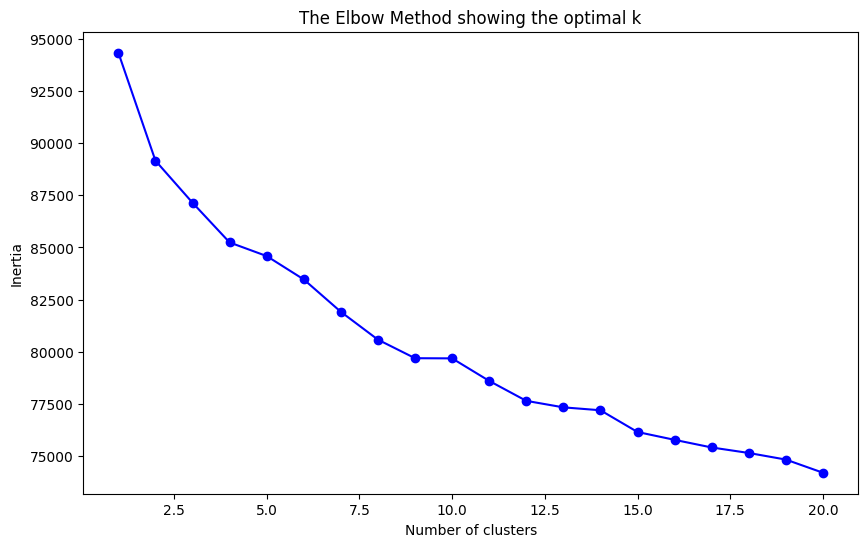

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(1,21)

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(embedding)
    inertia.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [17]:
# above the elbow occurs at k = 6
kmeans = KMeans(n_clusters=6)
kmeans.fit(embedding)
labels = kmeans.labels_

In [18]:
import umap
import seaborn as sns

reducer = umap.UMAP()
umap_embeddings = reducer.fit_transform(embedding)

# plt.figure(figsize=(12, 8))
# scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap='Spectral')
# plt.title('2D UMAP Representation of Document Embeddings')
# plt.xlabel('UMAP Dimension 1')
# plt.ylabel('UMAP Dimension 2')
# plt.colorbar(scatter)
# plt.show()

plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap='Spectral', s=5, alpha=0.5)

# Plot cluster centers
centroids = reducer.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=50, marker='x')

plt.title('2D UMAP Representation of Document Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(scatter)
plt.show()

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
from scipy.spatial import distance
import numpy as np

# Select two clusters to analyze
selected_clusters = [0, 1]  # For example, clusters 0 and 1

# Find the embeddings for documents in the selected clusters
for cluster_num in selected_clusters:
    # Filter the embeddings to include only those in the current cluster
    cluster_embeddings = embedding[labels == cluster_num]

    # Calculate the centroid of the cluster
    centroid = kmeans.cluster_centers_[cluster_num]

    # Calculate the distance of each embedding in the cluster to the centroid
    distances = distance.cdist([centroid], cluster_embeddings, 'euclidean')[0]

    # Get the indices of the 10 closest embeddings
    closest_indices = np.argsort(distances)[:10]

    # Retrieve the corresponding documents
    closest_docs = alternatives_messages[labels == cluster_num].iloc[closest_indices]

    # Display the information
    print(f"Cluster {cluster_num}:")
    print(closest_docs['text'])
    print()  # Add an empty line for better readability between clusters


Cluster 0:
106009    https://t.co/jzfnsQVuUS Hi Soulla, I thought t...
102163    I need to share something with you. Last Sunda...
99248     Beginning of the decade: a school trip to Fran...
100850    I suspect @arthur_spirling has hit the key poi...
108210    Attente sous moy.journ.:Cabane des Robinson(La...
100488    @KleinRevd @Triplejay58 Simply put, they won't...
99438     #TRLT A3: you may not be able to tell from thi...
99218     March 2019: Hit an ATL roof with a 16-person d...
105080    no one gets this photo perspective. you have t...
101337    @HillF1 @simon__lazenby @GretaThunberg What a ...
Name: text, dtype: object

Cluster 1:
106837    "This case went very well, and we look forward...
106829    If you are looking at purchasing an aircraft, ...
99973     A lot of people had the idea that Aero and Mar...
107196    "...there was a lot of different ways to go ab...
107108    "To have our own plane, it cuts the flight tim...
105923    An Aircraft Sales and Use Tax Firm's Key 

# Question 3 - LDA

* Use the complete corpus
* We will tokenize the corpus
* Create a LDA model with 8 topics

___


**TOKENIZATION**
* Consider the lowercased corpus
* Use the `TweetTokenizer` from NLTK
* For tokenization, consider the following:
  * Remove the english stopwords (from the NLTK list of stopwords)
  * Consider `"rt"` as a stopword
  * Keep only the tokens made of letters only, at least 3 letters
* Create a `gensim` Dictionary
  * Filter out tokens that appear in less than 5 documents
  * Filter out tokens that appear in more than 90% of the documents


___


**LDA**
* Create a LDAModel from gensim
* With 8 topics
* Display the word clouds corresponding to the Top-10 words in each topic



